In [659]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras import optimizers


## 1) The Dataset

#### Assuming you have a classification problem, is it binary, multi-class or multi-label?

I have a multi-class classification problem.

In [660]:
path = 'data/datasets-resized'

#Loading images from folder
import glob
import cv2
from skimage import io
from skimage.transform import resize

types = ['*.jpg', '*.jpeg']

#Creating list images and labels
images = []
labels = []

# Iterate the folder with glob
for fpath in glob.glob(path + '/*.jpg'): 
    # Read the image with OpenCV    
    im = cv2.imread(fpath) 
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # Assigning labels to images
    if 'glass' in fpath:
        label = 0 
    elif 'metal' in fpath:
        label = 1
    elif 'paper' in fpath:
        label = 2 
    elif 'plastic' in fpath:
        label = 3
    elif 'cardboard' in fpath:
        label = 4
        
    im_rgb = cv2.resize(im_rgb, (64, 64))
    #Put image array to X    
    #Put label to y    
    images.append(im_rgb)
    labels.append(label)
    
#Convert X and y to numpy array
images = np.array(images)
labels = np.array(labels)

#### Train/Test/validation sizes- Image size?

In [661]:
X_train, X_test, y_train, y_test = train_test_split(images,
                                                    labels,
                                                    test_size=1/10,
                                                    random_state=0)
                                                    
print(X_train.shape, X_test.shape)

(2152, 64, 64, 3) (240, 64, 64, 3)


In [662]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=1/9,
                                                  random_state=0)
                                                  
print(X_train.shape, X_val.shape, X_test.shape)

(1912, 64, 64, 3) (240, 64, 64, 3) (240, 64, 64, 3)


#### Show a few examples per class

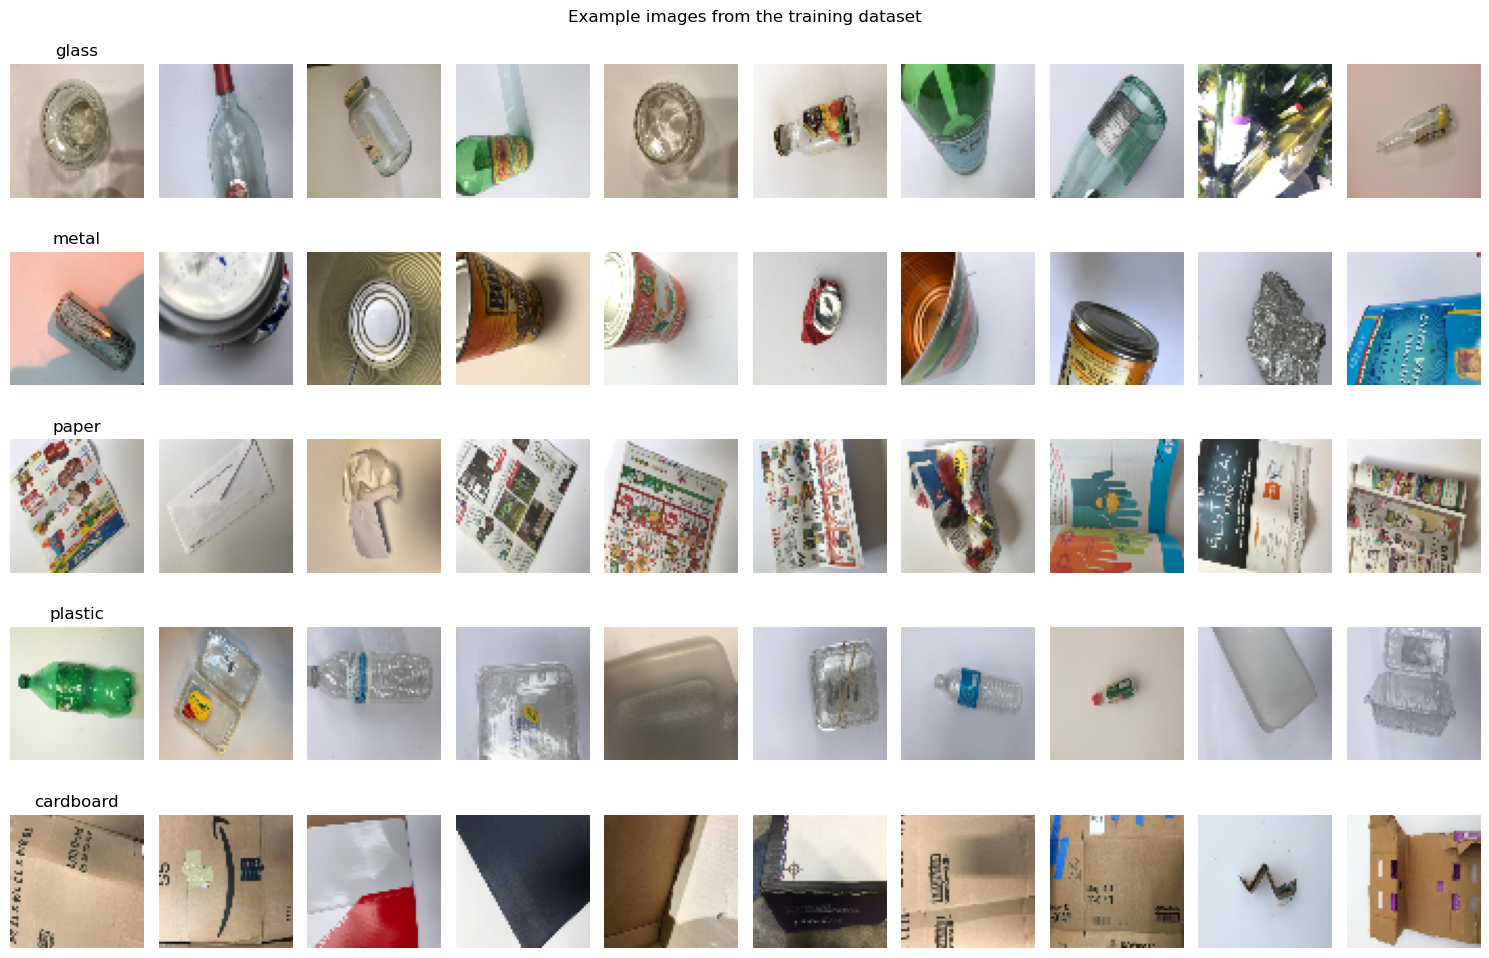

In [663]:
# Define the class names
class_names = ["glass", "metal", "paper", "plastic", "cardboard"]

# Identify the different classes in the dataset
num_classes = len(class_names)
class_indices = [np.where(y_train == i)[0] for i in range(num_classes)]

# Select 10 example images for each class
num_examples = 10
fig, axes = plt.subplots(num_classes, num_examples, figsize=(15, 10))

for i in range(num_classes):
    for j in range(num_examples):
        # Select a random image index from the current class
        idx = np.random.choice(class_indices[i])
        # Display the image
        axes[i, j].imshow(X_train[idx])
        axes[i, j].axis("off")
        # Add the class label as the title
        if j == 0:
            axes[i, j].set_title(class_names[i])
            
plt.suptitle("Example images from the training dataset")
plt.tight_layout()
plt.show()

#### How many classes?

I have 5 different classes: glass, metal, paper, plastic and cardboard.

#### How many images per class?

In [664]:
for class_name in class_names:
    images = [f for f in os.listdir(path) if f.startswith(class_name) and os.path.isfile(os.path.join(path, f))]
    print(f"Class: {class_name}, Number of Images: {len(images)}")

Class: glass, Number of Images: 501
Class: metal, Number of Images: 409
Class: paper, Number of Images: 594
Class: plastic, Number of Images: 480
Class: cardboard, Number of Images: 408


#### How are the images labeled?

The filenames of the images carry the label information along with a unique identifier. For instance, an image depicting a cardboard material may have a filename such as "cardboard123.jpg", where "cardboard" represents the label and "123" is a unique identifier assigned to the image.

#### Dataset source(s)?

- https://github.com/garythung/trashnet
- imsitu dataset

## 2) Baselines

#### Random guess accuracy?

I have 5 classes so my random guess accuracy is 20%.

#### Human-Level Performance accuracy?

https://forms.office.com/e/3P7z31jPHu

#### Multilayer Perceptron accuracy?

In [665]:
#score = model.evaluate(X_test, y_test, verbose=0)
# print("Test accuracy:", score[1])


## 3) Preprocessing

#### Explain all the preprocessing steps you did.

## 4) CNN Architecure

In [666]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(10, activation='softmax')) # 10 is the number of classes

## 5) CNN training

In [667]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Loss function/Optimizer (with its hyper-parameters)/Metrics

#### Learning curves

In [675]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
history = model.fit(X_train, y_train, batch_size=32, epochs=20, callbacks=early_stopping, validation_data=(X_test, y_test))

Epoch 1/20
60/60 [==============================] - 2s 38ms/step - loss: 0.2589 - accuracy: 0.9085 - val_loss: 1.6636 - val_accuracy: 0.6083
Epoch 2/20
60/60 [==============================] - 2s 38ms/step - loss: 0.2636 - accuracy: 0.9121 - val_loss: 2.0596 - val_accuracy: 0.5417
Epoch 3/20
60/60 [==============================] - 2s 38ms/step - loss: 0.4444 - accuracy: 0.8379 - val_loss: 2.0460 - val_accuracy: 0.5167
Epoch 4/20
60/60 [==============================] - 2s 38ms/step - loss: 0.1796 - accuracy: 0.9362 - val_loss: 2.4861 - val_accuracy: 0.5292
Epoch 5/20
60/60 [==============================] - 2s 35ms/step - loss: 0.1189 - accuracy: 0.9603 - val_loss: 2.1891 - val_accuracy: 0.5542
Epoch 6/20
60/60 [==============================] - 2s 38ms/step - loss: 0.1267 - accuracy: 0.9603 - val_loss: 2.1599 - val_accuracy: 0.6042
Epoch 6: early stopping


In [676]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 13ms/step - loss: 2.1599 - accuracy: 0.6042


[2.1599326133728027, 0.6041666865348816]

## 6) Model performance

#### Metrics plots

In [670]:
# code #

# Confusion Matrix
# Row labels
# Col predictions
#pd.DataFrame(cm)

In [671]:
# Metrics
# code #
#print('Accuracy:', np.round(acc, 4))
#print('Precision:', np.round(precision, 4))
#print('Recall:', np.round(recall, 4))
#print('F1 Score:', np.round(f1, 4))

In [672]:
# Baseline comparison
#pd.DataFrame({'Random guess (%)': [10],
              #'MLP(%)': [95],
              #'CNN(%)':[np.round(acc, 3)*100],
              #'HLP(%)':[99.9]})

## 7) Error analysis

#### Top error interpretation